In [22]:
import pickle
import typhon
import numpy as np
import analysis_tools as atools
import matplotlib.pyplot as plt
from os.path import join
from netCDF4 import Dataset
from moisture_space import plots
from scipy.interpolate import interp1d, interp2d
plt.style.use(typhon.plots.styles.get('typhon'))

In [35]:
models = ['ICON', 'NICAM', 'GEOS', 'IFS', 'SAM', 'FV3', 'MPAS', 'UM', 'ARPEGE']
runs = {
    'ICON': ['2.5km'],
    'NICAM': ['3.5km'],
    'SAM': ['4.0km'],
    'UM': ['5.0km'],
    'FV3': ['3.25km'],
    'GEOS': ['3.0km'],
    'IFS': ['4.0km', '9.0km'],
    'MPAS': ['3.75km'],
    'ARPEGE': ['2.5km'],
    'ERA5': ['31.0km']
}
exps = []
for m in models:
    for run in runs[m]:
        exps.append(m+'-'+run)
variables = ['QI', 'IWP']    
time_period = ['0810', '0908']
datapath = '/mnt/lustre02/work/mh1126/m300773/DYAMOND/{}/random_samples/'
filenames = '{}_{}_sample_{}_{}-{}.nc'
filename_cloudsat = '/mnt/lustre02/work/mh1126/m300773/CloudSat/2016/iwc_profiles_zip.nc'
height = dict.fromkeys(models)
num_levels = dict.fromkeys(models)
num_profiles = 10000000
h = np.arange(50, 20100, 100)
for exp in exps:
    filename = filenames.format(exp, variables[0], num_profiles, time_period[0], time_period[1])
    filename = join(datapath.format(exp.split('-')[0]), filename)
    #xarr = xr.open_dataset(filename)
    with(Dataset(filename)) as ds:
        height[exp] = ds.variables['height'][:].filled(np.nan)
    num_levels[exp] = len(height[exp])

In [36]:
with Dataset(filename_cloudsat) as ds:
    iwc_cloudsat = ds.variables['iwc'][:].filled(np.nan)
    height_cloudsat = ds.variables['z'][:].filled(np.nan)

In [37]:
profiles = {}
for exp in exps:
    print(exp)
    profiles[exp] = {}
    for var in variables:
        filename = filenames.format(exp, var, num_profiles, time_period[0], time_period[1])
        filename = join(datapath.format(exp.split('-')[0]), filename)
        with(Dataset(filename)) as ds:
            profiles[exp][var] = ds.variables[var][:].filled(np.nan)  
        #cloudy_profiles[exp] = profiles[exp]['IWP'] > 1e-3

ICON-2.5km
NICAM-3.5km
GEOS-3.0km
IFS-4.0km
IFS-9.0km
SAM-4.0km
FV3-3.25km
MPAS-3.75km
UM-5.0km
ARPEGE-2.5km


In [38]:
k = 10
qi_interp = {}
profiles_thinned = {}

for exp in exps:
    print(exp)
    x = np.arange(0, profiles[exp]['QI'].shape[1], k)
    profiles_thinned[exp] = profiles[exp]['QI'][:, ::k]
    profiles_thinned[exp][np.isnan(profiles_thinned[exp])] = 0
    qi_interp[exp] = interp2d(x, height[exp], profiles_thinned[exp], bounds_error=False, fill_value=np.nan)(x, h)

ICON-2.5km
NICAM-3.5km
GEOS-3.0km
IFS-4.0km
IFS-9.0km
SAM-4.0km
FV3-3.25km
MPAS-3.75km
UM-5.0km
ARPEGE-2.5km


In [39]:
# tropical mean density profiles
with open('/mnt/lustre02/work/mh1126/m300773/DYAMOND/Intermediate_data/density_profiles.pkl', 'rb') as infile:
    density_profiles = pickle.load(infile)

density_interp = {}
for exp in exps:
    density_interp[exp] = interp1d(density_profiles['height'], density_profiles[exp], bounds_error=False)(h)

In [40]:
qi_vol_interp = {}
for exp in exps:
    qi_vol_interp[exp] = qi_interp[exp] * np.expand_dims(density_interp[exp], 1)

In [41]:
def cloud_top_height(cloud_ice_content, height, thres=1e-5):
    return height[np.nanargmax(cloud_ice_content > thres, axis=0)]

In [42]:
thres = 1e-5
cth = {}
for exp in exps:
    cth[exp] = cloud_top_height(qi_vol_interp[exp], h, thres=thres)

cth_cloudsat = cloud_top_height(iwc_cloudsat.T, height_cloudsat, thres=thres)

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """
/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  import sys


Text(0.5, 0, 'PDF')

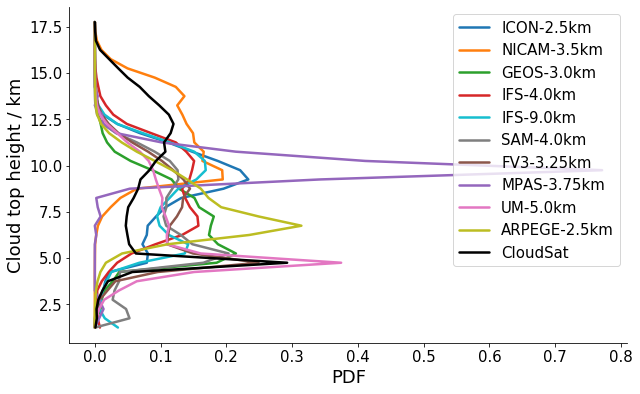

In [60]:
fig, ax = plt.subplots()
for exp in exps:
    bin_edges = np.arange(1., 18.1, 0.5)
    bin_centers = bin_edges[:-1] + 0.5 * np.diff(bin_edges) 
    hist, bin_edges = np.histogram(cth[exp] * 1e-3, bin_edges, normed=True)
    ax.plot(hist, bin_centers, color=plots.DYAMOND_colors(exp), lw=2.5, linestyle='-', label=exp)
hist_cloudsat, bin_edges = np.histogram(cth_cloudsat * 1e-3, bin_edges, normed=True)
ax.plot(hist_cloudsat, bin_centers, color='k', lw=2.5, linestyle='-', label='CloudSat')
ax.legend()
ax.set_ylabel('Cloud top height / km')
ax.set_xlabel('PDF')
#ax.hist(cth[exp] * 1e-3, bins=bins, histtype='step', color=plots.DYAMOND_colors(exp), lw=2.5, density=True)
#ax.set_xscale("log")
#ax.set_ylim(0, 0.3)
#ax.set_xlim(10, 18)

DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b3c426d1748>
DEBUG:Using auto colorbar locator on colorbar
DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b3c426d1748>
DEBUG:Setting pcolormesh


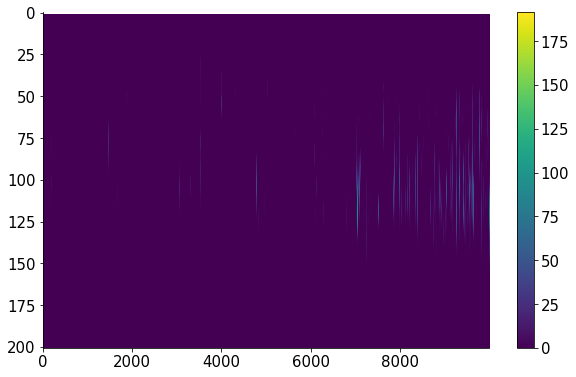

In [44]:
fig, ax = plt.subplots()
im = ax.imshow(qi_vol_interp['ICON-2.5km'][:, ::100] * 1e6, aspect='auto')
fig.colorbar(im)

In [ ]:
plt.imshow(profiles['ICON-2.5km']['QI'][:, ::1000], aspect='auto')

In [ ]:
height['IFS-4.0km']

In [ ]:
plt.plot(iwc_cloudsat, height_cloudsat*1e-3)

In [ ]:
h